In [1]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.naive_bayes import GaussianNB
import numpy as np
import lightgbm as lgb

In [2]:
PROCESSED_DATA_DIR = Path("data/processing_checkpoint")
checkpoint_file_path = PROCESSED_DATA_DIR / "03_10_day_window_sliced.parquet"
df_final = pd.read_parquet(checkpoint_file_path)

In [3]:
final_numerical_features = [
    "count_about", "count_total_sessions", "count_downgrade", "count_error",
    "thumbs_ratio", "ads_per_session", "frequency", "avg_songs_session", 
    "errors_per_session", "user_lifecycle_h", "count_roll_advert", "count_upgrade",
    "session_length_variance", "active_days_ratio", "hours_since_last_session",
    "unique_songs_ratio", "hours_since_downgrade", "is_new_user",
    "within_window_activity_ratio", "song_listening_change",
    "recent_activity_ratio", "session_depth_change",
    "cutoff_weekend"
]

final_categorical_features = [
    'last_level'
]

all_features = final_numerical_features + final_categorical_features
X = df_final[all_features]
y = df_final["label"]
print("Shape of Dataset loaded:", X.shape)



Shape of Dataset loaded: (60434, 24)


In [4]:
df_final["num_unique_songs"] = df_final["num_unique_songs"].fillna(0)

In [5]:
'''
from sklearn.feature_selection import SelectFromModel

# Build LASSO selector for meaningful feature selection
lasso_selector = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", SelectFromModel(
        LogisticRegression(
            penalty="l1", solver="liblinear", C=0.1,
            class_weight="balanced", random_state=42
        )
    ))
])

lasso_selector.fit(X[final_numerical_features], y)

# Get Boolean mask from LASSO
selected_mask = lasso_selector.named_steps["lasso"].get_support()

# print out selected feature from LASSO
selected_num_features = []
for feature_name, keep_bool in zip(final_numerical_features, selected_mask):
    if keep_bool == True:
        selected_num_features.append(feature_name)

print("Selected num features:", selected_num_features)
print("Count of selected num features", len(selected_num_features))

'''

'\nfrom sklearn.feature_selection import SelectFromModel\n\n# Build LASSO selector for meaningful feature selection\nlasso_selector = Pipeline([\n    ("scaler", StandardScaler()),\n    ("lasso", SelectFromModel(\n        LogisticRegression(\n            penalty="l1", solver="liblinear", C=0.1,\n            class_weight="balanced", random_state=42\n        )\n    ))\n])\n\nlasso_selector.fit(X[final_numerical_features], y)\n\n# Get Boolean mask from LASSO\nselected_mask = lasso_selector.named_steps["lasso"].get_support()\n\n# print out selected feature from LASSO\nselected_num_features = []\nfor feature_name, keep_bool in zip(final_numerical_features, selected_mask):\n    if keep_bool == True:\n        selected_num_features.append(feature_name)\n\nprint("Selected num features:", selected_num_features)\nprint("Count of selected num features", len(selected_num_features))\n\n'

In [6]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Preprocessor
preprocessor_final = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), final_categorical_features),
        ("num", StandardScaler(), final_numerical_features)
    ],
    remainder="drop"
)

# Logistic Regression with SMOTE
log_reg_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor_final),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        random_state=42
    ))
])


In [7]:
# Define Models and Random Search Space

# Base Pipeline
base_pipeline = ImbPipeline([
    ("preprocessor", preprocessor_final),
    ("smote", SMOTE(random_state=42)),   # add smote only to lr
    ("classifier", LogisticRegression())
])


# Logistic Regression model
log_reg = LogisticRegression(
    #penalty="l1",        # lasso for feature selection
    solver="liblinear",
    random_state=42
)

# Random Forest
rf = RandomForestClassifier(
    class_weight="balanced_subsample",
    random_state=42
)

# XGB imbalance weight
neg = (y == 0).sum()
pos = (y == 1).sum()
xgb_scale = neg / pos

xgb = XGBClassifier(
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

lgbm = lgb.LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    random_state=42
)

In [8]:
model_candidates = [
    # Logistic Regression (with SMOTE)
    {
        "classifier": [log_reg],
        "classifier__C": np.logspace(-2, 2, 5)
    },

    # Random Forest (NO SMOTE)
    {
        "classifier": [rf],
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [5, 10, 15]
    },

    # XGB (NO SMOTE, use scale_pos_weight)
    {
        "classifier": [xgb],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [3, 5],
        "classifier__scale_pos_weight": [xgb_scale]
    },

    # LightGBM (NO SMOTE)
    {
        "classifier": [lgbm],
        "classifier__num_leaves": [31, 63, 127],
        "classifier__max_depth": [-1, 5, 10]
    }
]


In [9]:
# Group-Fold CV + Randomized Search

from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

groups = df_final["snapshot_day"]
cv = GroupKFold(n_splits=4)

random_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=model_candidates,
    n_iter=20,
    scoring="roc_auc",
    cv=cv.split(X, y, groups),
    verbose=2,
    n_jobs=-1,
    random_state=42,
    error_score='raise'   #check error
)

random_search.fit(X, y)

best_model = random_search.best_estimator_
best_score = random_search.best_score_

print("Best AUC:", best_score)
print("Best classifier:", best_model["classifier"])
print("Best params:", random_search.best_params_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


c:\Users\Jessie\anaconda3\envs\py311\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Best AUC: 0.726117969358381
Best classifier: LogisticRegression(C=np.float64(0.01), random_state=42, solver='liblinear')
Best params: {'classifier__C': np.float64(0.01), 'classifier': LogisticRegression(random_state=42, solver='liblinear')}


In [10]:
PROCESSED_DATA_DIR = Path("data/processing_checkpoint")
checkpoint_file_path = PROCESSED_DATA_DIR / "04_user_base_test.parquet"
df_test = pd.read_parquet(checkpoint_file_path)
X_test = df_test[all_features]

y_pred = best_model.predict(X_test)
submission_df = pd.DataFrame({
    "id": df_test["userId"],
    "target": y_pred
})
submission_df.to_csv("submission_Jessie.csv", index=False)

print("Submission saved as submission_Jessie.csv")


Submission saved as submission_Jessie.csv


In [11]:
import pandas as pd

feature_names = best_model['preprocessor'].get_feature_names_out()
print("Final features count:", len(feature_names))
print(pd.DataFrame(feature_names, columns=["feature"]))

Final features count: 24
                              feature
0                cat__last_level_paid
1                    num__count_about
2           num__count_total_sessions
3                num__count_downgrade
4                    num__count_error
5                   num__thumbs_ratio
6                num__ads_per_session
7                      num__frequency
8              num__avg_songs_session
9             num__errors_per_session
10              num__user_lifecycle_h
11             num__count_roll_advert
12                 num__count_upgrade
13       num__session_length_variance
14             num__active_days_ratio
15      num__hours_since_last_session
16            num__unique_songs_ratio
17         num__hours_since_downgrade
18                   num__is_new_user
19  num__within_window_activity_ratio
20         num__song_listening_change
21         num__recent_activity_ratio
22          num__session_depth_change
23                num__cutoff_weekend


In [12]:
print(df_final.groupby("snapshot_day")["label"].value_counts())


snapshot_day  label
9             0        13355
              1          821
19            0        14635
              1          817
29            0        14741
              1          789
39            0        14613
              1          663
Name: count, dtype: int64


In [13]:
print("Total positives in full dataset:", y.sum())
print(df_final.groupby("snapshot_day")["label"].sum())

Total positives in full dataset: 3090
snapshot_day
9     821
19    817
29    789
39    663
Name: label, dtype: int64


===== MODEL PERFORMANCE (Train Set) =====
Accuracy:    0.7034
Precision:   0.1050
Recall:      0.6385
F1 Score:    0.1804
AUC Score:   0.7314


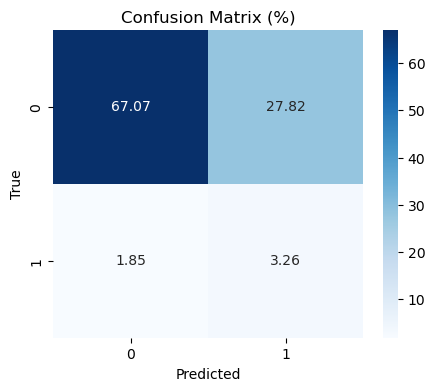


===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     57344
           1       0.11      0.64      0.18      3090

    accuracy                           0.70     60434
   macro avg       0.54      0.67      0.50     60434
weighted avg       0.93      0.70      0.79     60434



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# ---- 1. Predict on TRAIN set ----
y_pred = best_model.predict(X)

# ---- 2. AUC using probability ----
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_proba)
else:
    y_proba = None
    auc = None

print("===== MODEL PERFORMANCE (Train Set) =====")
print(f"Accuracy:    {accuracy_score(y, y_pred):.4f}")
print(f"Precision:   {precision_score(y, y_pred):.4f}")
print(f"Recall:      {recall_score(y, y_pred):.4f}")
print(f"F1 Score:    {f1_score(y, y_pred):.4f}")
if auc is not None:
    print(f"AUC Score:   {auc:.4f}")
else:
    print("AUC Score:   N/A (model has no predict_proba)")

# ---- 3. Confusion Matrix (in PERCENT) ----
cm = confusion_matrix(y, y_pred)
cm_percent = cm / cm.sum() * 100   # Convert counts → percentage

plt.figure(figsize=(5,4))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- 4. Full Classification Report ----
print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y, y_pred))


In [15]:
lr_clf = best_model['classifier']

feature_names_lr = best_model['preprocessor'].get_feature_names_out()

coefficients = lr_clf.coef_[0]

lr_importance_df = pd.DataFrame({
    'feature': feature_names_lr,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(lr_importance_df.head(15).to_markdown(index=False))

ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.